In [234]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

In [230]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [231]:
def w1(x):
    return ((2 * np.pi * x[..., 0]) / 4.0).sin()

def w2(x):
    exp_arg = -0.5 * ((x[..., 0] - 1) / 0.6).pow(2)
    return 3 * exp_arg.exp()

def w3(x):
    def sigmoid(v):
        return 1 / (1 + (-v).exp())
    
    return 3 * sigmoid((x[..., 0] - 1) / 0.3)

def parenthesis_energy(x):
    x = x + 1
    two_norm = torch.linalg.norm(x, ord=2, dim=-1)
    first_term = 0.5 * ((two_norm - 2) / 0.4).pow(2)
    
    first_exp_arg_term = -0.5 * ((x[..., 0] - 2) / 0.6).pow(2)
    second_exp_arg_term = -0.5 * ((x[..., 0] + 2) / 0.6).pow(2)
    
    ln_term = torch.stack([first_exp_arg_term, second_exp_arg_term]).logsumexp(0)
    
    return first_term - ln_term

def contiguous_squiglies_energy(x):
    mask  = (torch.abs(x) < 4)
    mask = mask.all(dim=-1)
    x = bound_data(x)

    return (0.5 * ((x[..., 1] - w1(x)) / 0.4).pow(2)) #* mask + ~mask * (10 +  torch.max(torch.abs(x)*5+10, dim=-1).values**2)

def middle_divergent_squiglies_energy(x):
    first_exp_arg = -0.5 * ((x[..., 1] - w1(x)) / 0.35).pow(2)
    scnd_exp_arg = -0.5 * ((x[..., 1] - w1(x) + w2(x)) / 0.35).pow(2)
    
    return -torch.stack([first_exp_arg, scnd_exp_arg]).logsumexp(0)

def end_divergent_squiglies_energy(x):
    first_exp_arg = -0.5 * ((x[..., 1] - w1(x)) / 0.4).pow(2)
    scnd_exp_arg = -0.5 * ((x[..., 1] - w1(x) + w3(x)) / 0.35).pow(2)
    
    return -torch.stack([first_exp_arg, scnd_exp_arg]).logsumexp(0)

class EnergyDistribution:
    def __init__(self, energy_fxn):
        self.energy_fxn = energy_fxn
        
    def log_prob(self, x):
        return -self.energy_fxn(x)

In [225]:
dim = 2
target = EnergyDistribution(contiguous_squiglies_energy)

In [226]:
# sample uniformly from the grid
num_grid = 800
limit = 4

X = torch.linspace(-limit, limit, num_grid)
Y = torch.linspace(-limit, limit, num_grid)

# create a grid of (x,y) coordinates
x = torch.meshgrid(X, Y)

# make x into tensor
x = torch.stack(x, dim=2).reshape(-1, 2)
x = x.to(device)

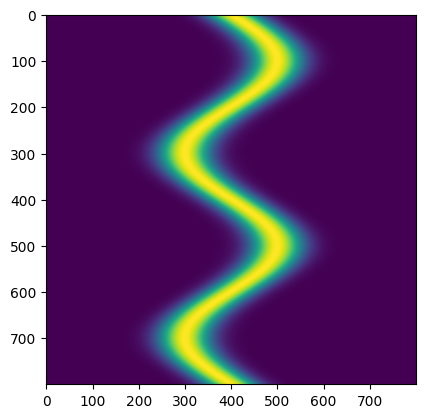

In [227]:
plt.imshow(target.log_prob(x).reshape(num_grid, num_grid).exp().cpu().detach().numpy())

### Helper Functions

In [194]:
def normalize(x):
    return x

def unnormalize(x, mins, maxs):
    return x

In [195]:
def bound_data(x):
    return (x + 4) % 8 - 4

## Function Definitions

### Estimated Reward Functions

In [196]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, beta, num_mc_samples, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = beta * repeated_t
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = target.log_prob(samples)
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = target.log_prob(samples)
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [197]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, 
                      randomness='different', in_dims=(0,0,None,None))(x, t, beta, 
                                                                       num_mc_samples, var_exploding=var_exploding)

In [198]:
def estimate_grad_Rt(
    x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False
):
    est_scores_n = torch.func.grad(log_E_R)(
        x, t, beta, num_mc_samples, var_exploding=var_exploding
    )
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(
            x, t, beta, num_mc_samples // 2, var_exploding=var_exploding
        )
        return 2 * est_scores_n - est_scores_n_div2
    else:
        return est_scores_n

### True Reward Functions

In [199]:
def true_Rt(x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * t
    target.convolve(h_t * (global_maxs **2), t, var_exploding=var_exploding)
    energy = target.log_prob(unnormalize(x, global_mins, global_maxs))
    target.reset()
    return energy

In [200]:
def true_grad_Rt(x, t, beta, var_exploding=True):
    # samples_energy = true_Rt(x, t[0], beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores

## SDE Tests

### Dataset

In [201]:
# dataset
beta = 4

num_samples = 2048

init_samples = torch.randn((num_samples, dim)) * beta
init_energy = target.log_prob(init_samples)

init_dataset = TensorDataset(init_samples, init_energy)
init_loader = DataLoader(init_dataset, batch_size = 512, shuffle=True) 

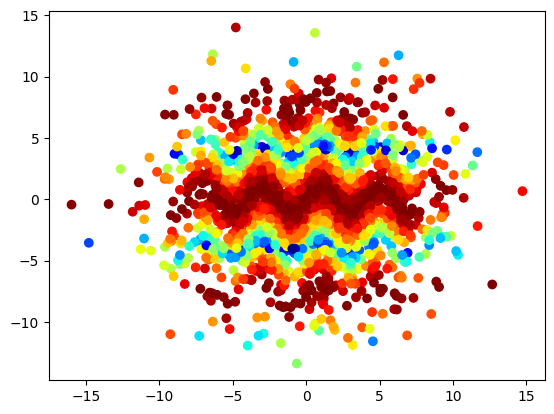

In [202]:
plt.scatter(init_samples[:, 0], init_samples[:, 1], c=init_energy, cmap='jet')

### VE SDE

In [203]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta

    def f(self, t, x):
        with torch.enable_grad():
            x.requires_grad = True
            score = torch.vmap(self.score, in_dims=(0, None, None), randomness="different")(x, (1-t).to(device), self.beta)
        return self.g(t, x) ** 2 * score

    def g(self, t, x):
        return torch.full_like(x, self.beta**0.5)

In [204]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0.001, 1.0, 500).to(device)
    with torch.no_grad():
        #samples = torchsde.sdeint(ve_reverse_sde, x_init, t)
        samples = integrate_sde(ve_reverse_sde,[0, 1], 0.001)
    return samples

In [205]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    pred_v = []
    true_v = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            pred_v.append(f)
            # true_v.append(true_grad_Rt(x, 1-t, beta))
    return torch.stack(samples), torch.stack(pred_v) # , torch.stack(true_v)

In [206]:
x1_samples = init_samples.to(device)
x1_samples.requires_grad = True

In [207]:
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt, beta)
samples, pred_vectors = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 0.001) #true_vectors
samples = samples[-1]

In [208]:
samples = bound_data(samples)

In [209]:
samples_energy = target.log_prob(samples)

In [210]:
import seaborn as sns

<Axes: >

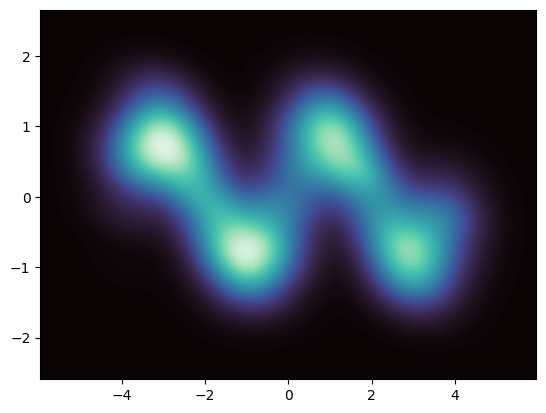

In [211]:
sns.kdeplot(x=samples[:, 0].cpu().detach().numpy(), y=samples[:, 1].cpu().detach().numpy(), fill=True, cmap='mako', levels=500, thresh=0)

<Axes: >

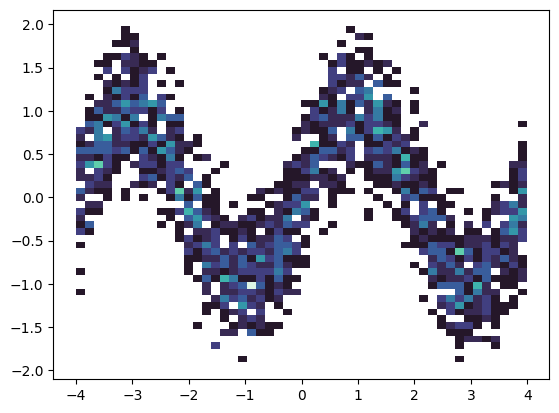

In [212]:
sns.histplot(x=samples[:, 0].cpu().detach().numpy(), y=samples[:, 1].cpu().detach().numpy(), bins=50, cmap='mako', thresh=0)

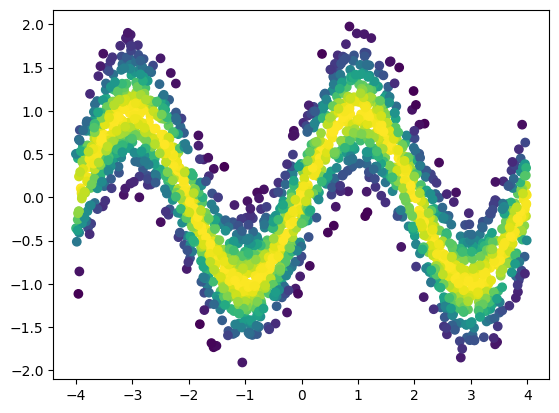

In [213]:
plt.scatter(samples[:, 0].detach().cpu(), samples[:, 1].detach().cpu(), c=samples_energy.exp().cpu().detach().numpy())

### Training

In [214]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)

            x.requires_grad = True
            score = self.score(x, 1-t, self.beta)
        return self.g(t, x)**2 * score 
    
    def g(self, t, x):
        return torch.full_like(x, self.beta ** 0.5)

In [215]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0.001, 1.0, 500).to(device)
    with torch.no_grad():
        #samples = torchsde.sdeint(ve_reverse_sde, x_init, t)
        samples, _ = integrate_sde(ve_reverse_sde, x_init, [0, 1], 0.001)
    return samples

In [216]:
def reward_matching_loss_biased(vectorfield, x, t, beta):     
    h_t = beta * t.unsqueeze(1)
    x.requires_grad = True

    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = vectorfield(noisy_x, t)

    estimated_scores = torch.vmap(estimate_grad_Rt, in_dims=(0, 0, None), randomness="different")(noisy_x, t, beta)
    return ((estimated_scores - pred_scores)**2).mean()

In [249]:
def score_loss(vectorfield, x, t):
    h_t = beta * t.unsqueeze(1)
    # x(t)
    x_t = torch.normal(x, h_t ** 0.5)
    s_pred = vectorfield(x_t, t)

    s_true = - (x_t - x)/ h_t 
    return ((s_pred - s_true)**2).mean()    

In [250]:
beta = 20
vectorfield = MyMLP().to(device)
opt_vectorfield = Adam(vectorfield.parameters(), lr=1e-4)

In [251]:
buffer = SimpleBuffer(2, 10000, 1000, initial_sampler=None, 
                      device=device, fill_buffer_during_init=False, sample_with_replacement=True, prioritize=False)
buffer.add(init_samples, init_energy)

Buffer not initialised, expected that checkpoint will be loaded.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 21.496874
Epoch 49 | Loss 14.439043
Epoch 98 | Loss 13.137716


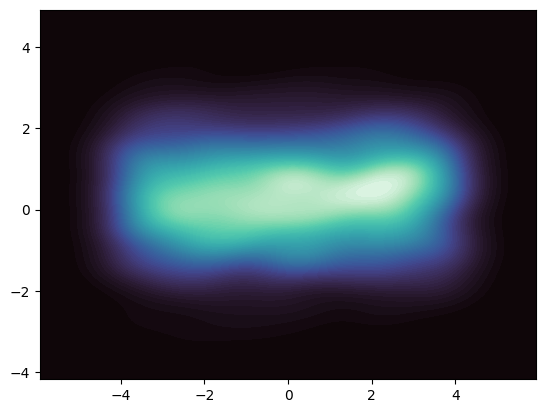

  1%|          | 1/100 [00:08<14:41,  8.90s/it]

Epoch 0 | Loss 9.462483
Epoch 49 | Loss 76.188980
Epoch 98 | Loss 11.394160


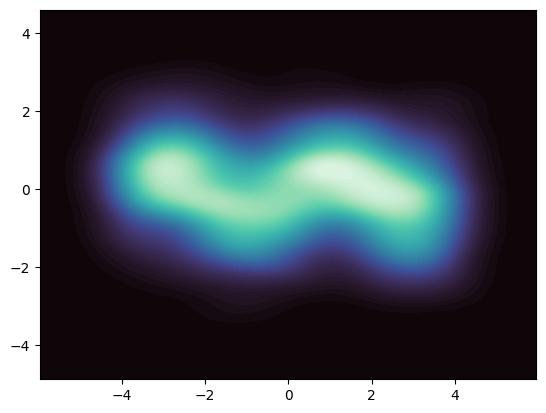

  2%|▏         | 2/100 [00:27<23:32, 14.42s/it]

Epoch 0 | Loss 8.556843
Epoch 49 | Loss 7.833390
Epoch 98 | Loss 5.995504


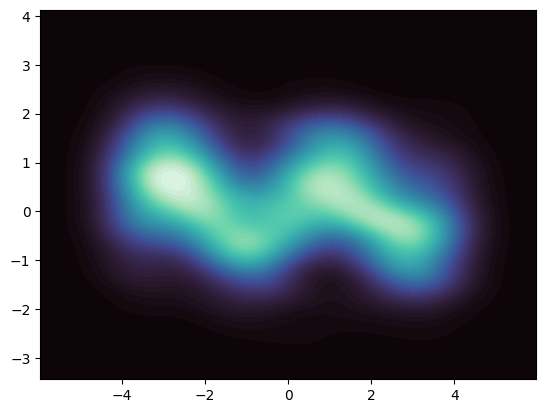

  3%|▎         | 3/100 [00:45<26:03, 16.12s/it]

Epoch 0 | Loss 5.649375
Epoch 49 | Loss 8.735794
Epoch 98 | Loss 8.066500


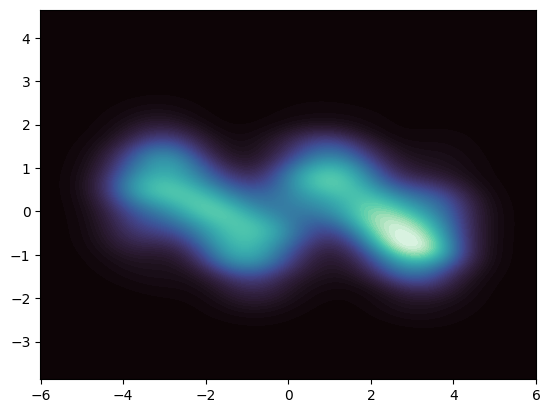

  4%|▍         | 4/100 [01:03<27:12, 17.00s/it]

Epoch 0 | Loss 6.431078
Epoch 49 | Loss 12.800121
Epoch 98 | Loss 3.422733


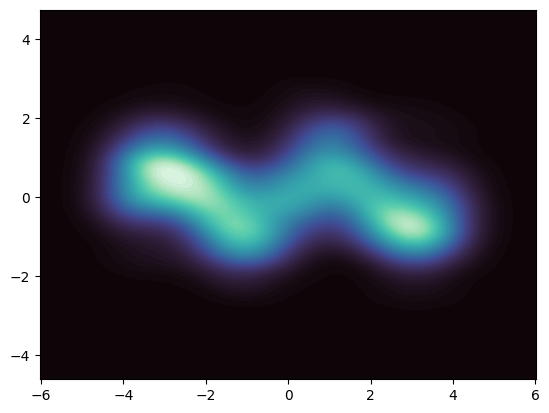

  5%|▌         | 5/100 [01:21<27:36, 17.44s/it]

Epoch 0 | Loss 3.209298
Epoch 49 | Loss 8.213337
Epoch 98 | Loss 4.295251


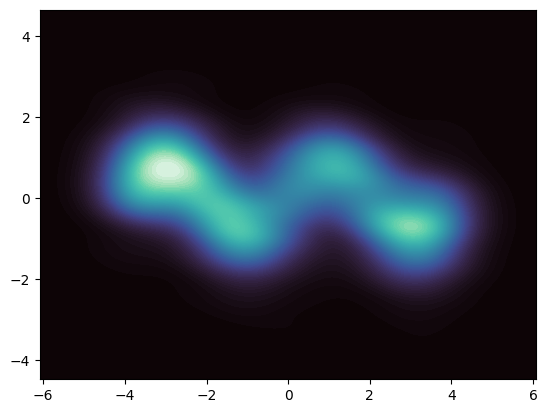

  6%|▌         | 6/100 [01:40<27:41, 17.67s/it]

Epoch 0 | Loss 4.325539
Epoch 49 | Loss 3.174451
Epoch 98 | Loss 2.998864


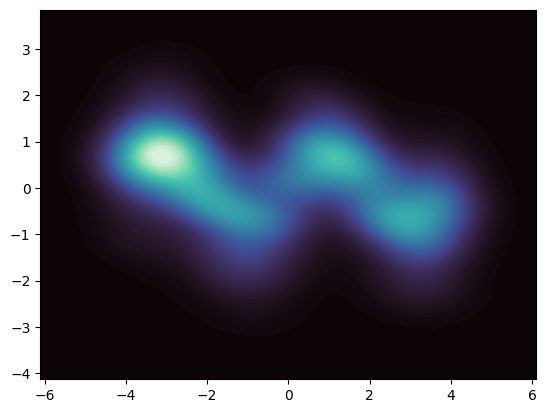

  7%|▋         | 7/100 [01:58<27:48, 17.94s/it]

Epoch 0 | Loss 4.035878
Epoch 49 | Loss 1.820919
Epoch 98 | Loss 2.855667


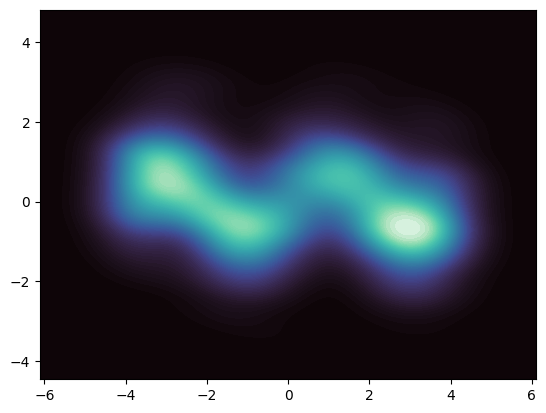

  8%|▊         | 8/100 [02:16<27:41, 18.06s/it]

Epoch 0 | Loss 2.704772
Epoch 49 | Loss 3.357728
Epoch 98 | Loss 2.502623


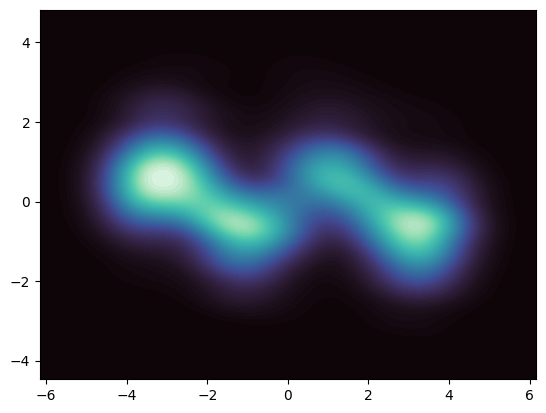

  9%|▉         | 9/100 [02:35<27:29, 18.13s/it]

Epoch 0 | Loss 82.706596
Epoch 49 | Loss 27.127241
Epoch 98 | Loss 3.004004


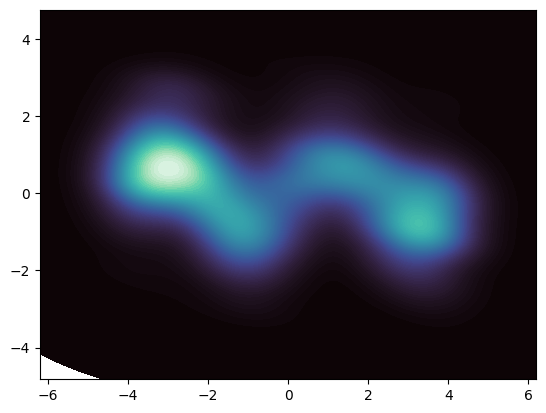

 10%|█         | 10/100 [02:53<27:13, 18.15s/it]

Epoch 0 | Loss 3.439728
Epoch 49 | Loss 3.374487
Epoch 98 | Loss 4.104309


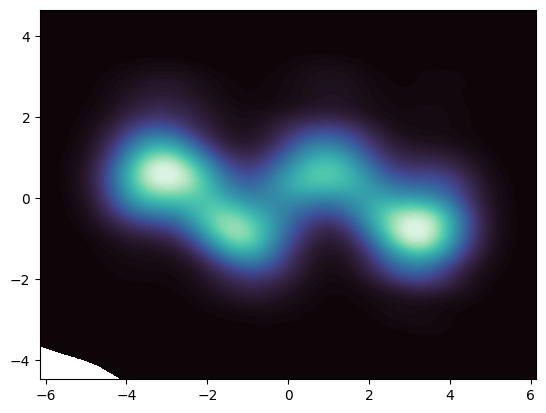

 11%|█         | 11/100 [03:11<26:57, 18.17s/it]

Epoch 0 | Loss 2.026552
Epoch 49 | Loss 2.858985
Epoch 98 | Loss 10.485665


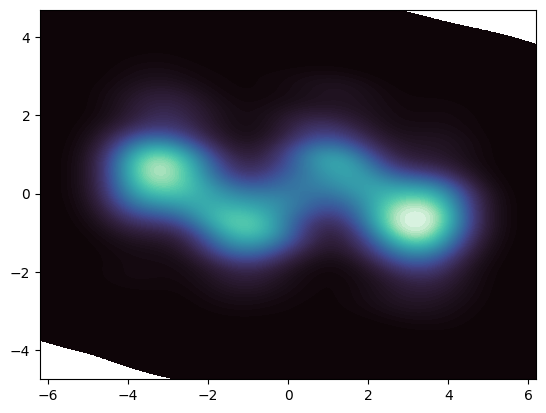

 12%|█▏        | 12/100 [03:30<26:49, 18.29s/it]

Epoch 0 | Loss 3.497487
Epoch 49 | Loss 4.449231
Epoch 98 | Loss 2.617582


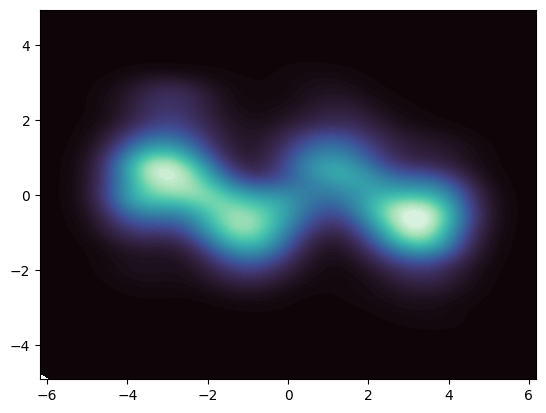

 13%|█▎        | 13/100 [03:48<26:23, 18.20s/it]

Epoch 0 | Loss 45.234577
Epoch 49 | Loss 8.316833
Epoch 98 | Loss 2.481634


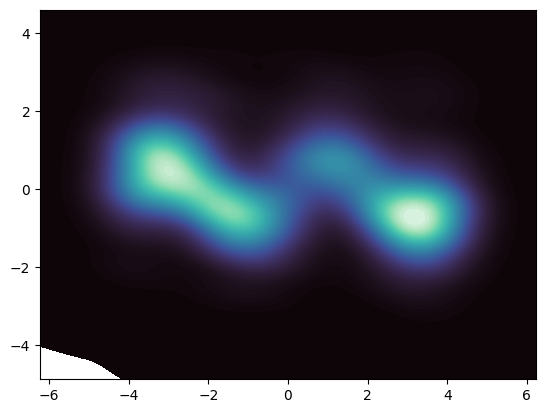

 14%|█▍        | 14/100 [04:06<26:11, 18.27s/it]

Epoch 0 | Loss 6.992052
Epoch 49 | Loss 2.578814
Epoch 98 | Loss 43.997074


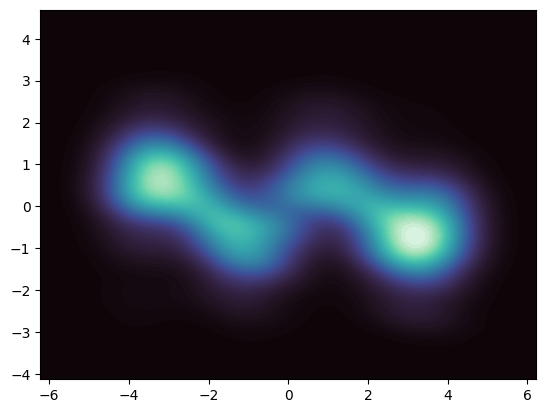

 15%|█▌        | 15/100 [04:24<25:54, 18.28s/it]

Epoch 0 | Loss 6.704600
Epoch 49 | Loss 2.505140
Epoch 98 | Loss 2.954877


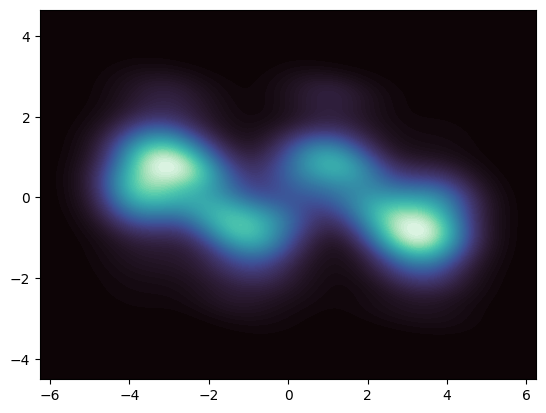

 16%|█▌        | 16/100 [04:42<25:25, 18.17s/it]

Epoch 0 | Loss 6.117095
Epoch 49 | Loss 4.915581
Epoch 98 | Loss 2.812095


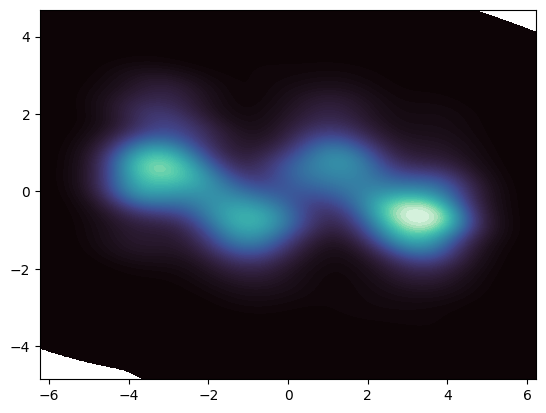

 17%|█▋        | 17/100 [05:01<25:13, 18.23s/it]

Epoch 0 | Loss 2.613866
Epoch 49 | Loss 3.619905
Epoch 98 | Loss 4.523971


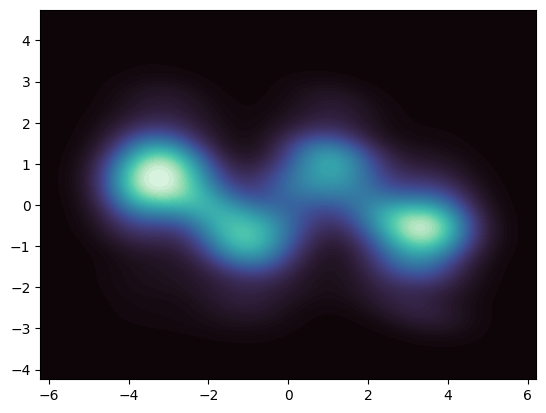

 18%|█▊        | 18/100 [05:19<24:46, 18.13s/it]

Epoch 0 | Loss 2.510414
Epoch 49 | Loss 2.247706
Epoch 98 | Loss 3.289052


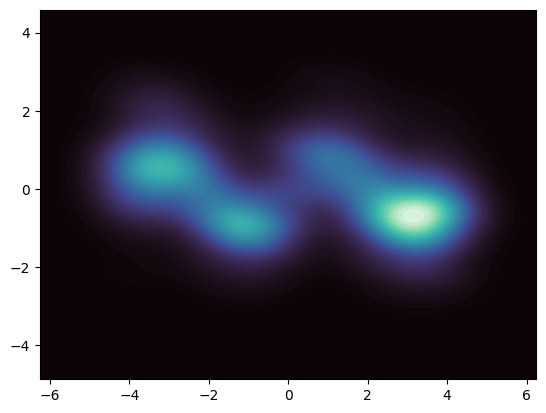

 19%|█▉        | 19/100 [05:36<24:22, 18.05s/it]

Epoch 0 | Loss 3.316445
Epoch 49 | Loss 2.530449
Epoch 98 | Loss 6.487762


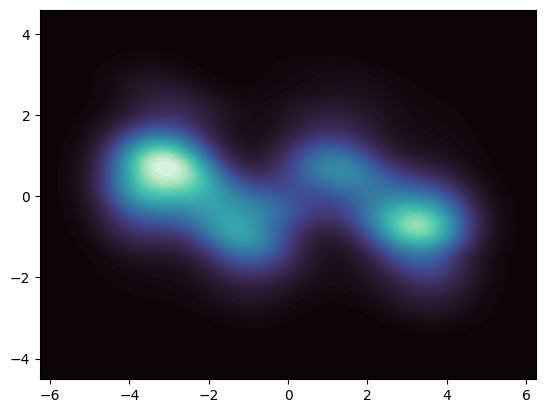

 20%|██        | 20/100 [05:55<24:13, 18.17s/it]

Epoch 0 | Loss 2.776870
Epoch 49 | Loss 2.950468
Epoch 98 | Loss 3.685454


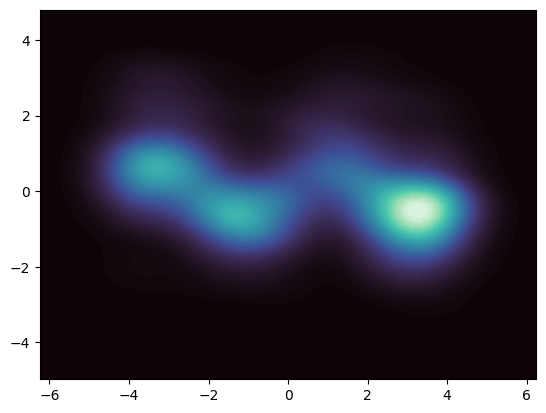

 21%|██        | 21/100 [06:13<23:55, 18.18s/it]

Epoch 0 | Loss 3.327010
Epoch 49 | Loss 19.220385
Epoch 98 | Loss 3.047370


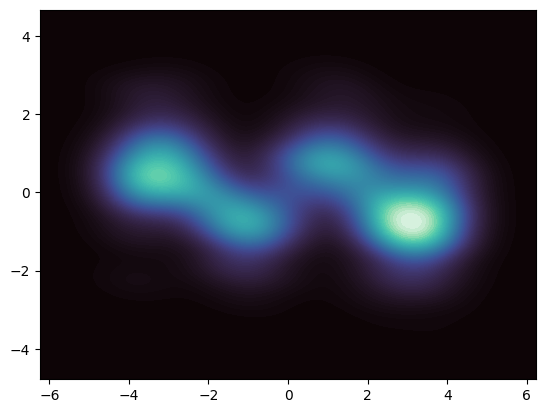

 22%|██▏       | 22/100 [06:31<23:41, 18.22s/it]

Epoch 0 | Loss 2.953248
Epoch 49 | Loss 3.467290
Epoch 98 | Loss 4.587413


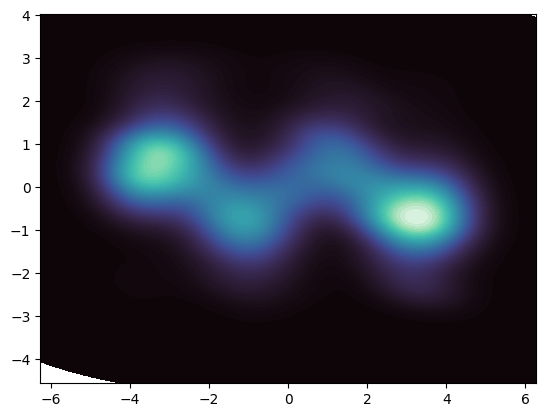

 23%|██▎       | 23/100 [06:50<23:23, 18.23s/it]

Epoch 0 | Loss 5.614297
Epoch 49 | Loss 3.908615
Epoch 98 | Loss 5.179546


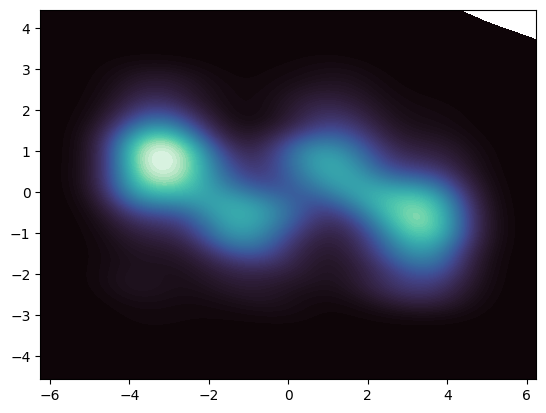

 24%|██▍       | 24/100 [07:07<22:56, 18.12s/it]

Epoch 0 | Loss 4.528760
Epoch 49 | Loss 2.898118
Epoch 98 | Loss 11.922396


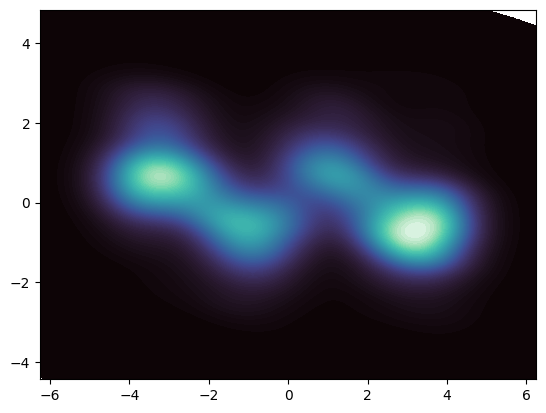

 25%|██▌       | 25/100 [07:25<22:34, 18.06s/it]

Epoch 0 | Loss 2.980000
Epoch 49 | Loss 2.845558
Epoch 98 | Loss 4.672380


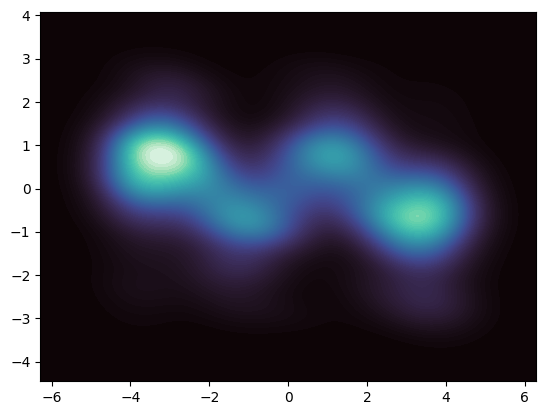

 26%|██▌       | 26/100 [07:44<22:22, 18.14s/it]

Epoch 0 | Loss 3.650167
Epoch 49 | Loss 4.727288
Epoch 98 | Loss 2.621445


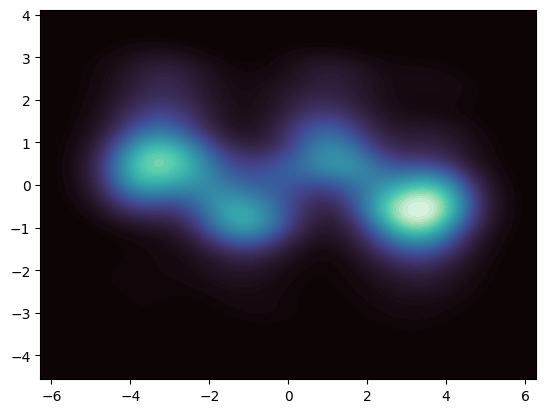

 27%|██▋       | 27/100 [08:02<22:04, 18.15s/it]

Epoch 0 | Loss 17.421278


 27%|██▋       | 27/100 [08:02<21:45, 17.88s/it]


KeyboardInterrupt: 

In [252]:
outer_epochs= 100
inner_epochs = 100

num_samples = 2048 

train_dataset = TensorDataset(init_samples.clone(), init_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True) 


for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            opt_vectorfield.zero_grad()
            # t = torch.rand(len(samples), device=device)

            # 80 % sample from (0, 0.1), 20% sample from (0.1, 1)
            # x0 is data
            low_time_t = (-0.1 * torch.rand(len(samples), device=device)) + 0.1
            high_time_t = (-0.9 * torch.rand(len(samples), device=device)) + 1.0
            
            mask = torch.rand(len(samples), device=device) < 0.8
            
            t = (low_time_t * mask) + (high_time_t * ~mask)

            loss = score_loss(vectorfield, samples, t) + reward_matching_loss_biased(vectorfield, samples, t, beta) 
            total_loss += loss.item()
            loss.backward()
            opt_vectorfield.step()
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the vector field
    ve_reverse_sde = VEReverseSDE(vectorfield, beta)
    samples = generate_samples(ve_reverse_sde, init_samples.detach().clone().to(device))[-1]
    samples = bound_data(samples)
    samples_energy = target.log_prob(init_samples).detach()

    # Update Buffer 
    buffer.add(samples, samples_energy)
    sns.kdeplot(x=samples[:, 0].cpu().detach().numpy(), y=samples[:, 1].cpu().detach().numpy(), fill=True, cmap='mako', levels=100, thresh=0)
    plt.show()
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)